In [1]:
#### FIRST 4 CELLS: specify frameworks, external imports, and the exact brain checkpoint used.
# The other cells specify funcs for the widget, which is at the bottom
# did you remember to change the 'device' in general_framework.py ?
from tutorialQA_framework import *
from tutorial1_framework import *
# add more here, or comment out

device = torch.device('cuda:1') # let's use the alligator GPU
device

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
🔥 text_pretraining_data/eng_sentences_pruned-train.txt
🔥 text_pretraining_data/eng_sentences_pruned-eval.txt


device(type='cuda', index=1)

In [2]:
from visual_transformer import *
from visual_transformer.enhanced_model import *

In [3]:
model = EnhancedAgentBrain()
model.move_to(device) # special function that wraps 'to'. Dumb? yes. Needed? Also yes.
# A little extra code to avoid weird error
model.memory.remember(torch.randn(16, 1, 768).to(device))
model.load_state_dict(torch.load('brain_checkpoints/enhanced_brain_first_training_v2_batch160799.pth', weights_only=True, map_location=device))
model.reset()

In [4]:
# Some other elements to use

from game import *

game_settings = BIG_tool_use_advanced_2_5
game_settings.gameSize = 224 # for compatibility with brain's expected size
G = discreteGame(game_settings)

####

#For this time:
def reset_G():
    global G
    G = discreteGame(G.random_bare_settings(gameSize=224, max_agent_offset=0.5))

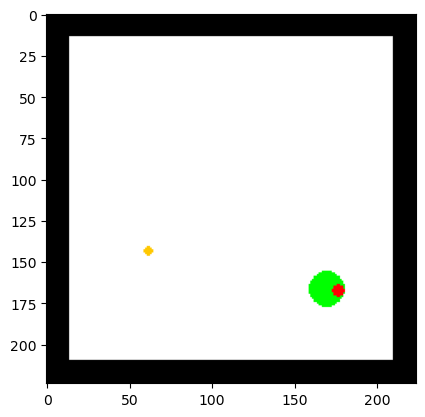

In [5]:
import matplotlib.pyplot as plt
reset_G()
plt.imshow(G.getData())

In [6]:
# THis notebook is to show the EnhancedBrain input, output, and state of mind at once.
# I'll start with a rough version and make it cleaner over time

In [7]:
from IPython.display import display
from ipywidgets import widgets

import numpy as np
import matplotlib.pyplot as plt

import time


In [8]:
device = torch.device('cuda:1')

In [9]:
def pre_imshow_numpy(torch_img, imshow=False):
    clean = torch_img.detach()[0].cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)
    return array

In [10]:
output = widgets.Output(layout={'border': '1px solid black'})

In [11]:
#model = EnhancedAgentBrain()
#model.move_to(device)
#2+2
# commment to prevent output

In [12]:
vocab_size = 10000
# tokenizer.save_model(".", "tokenizer/eng_sentences_tokenizer_vc10000")
tokenizer = ByteLevelBPETokenizer(
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-vocab.json",
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-merges.txt",
)   
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)   
tokenizer.enable_truncation(max_length=32)
tokenizer.enable_padding()

In [13]:
T = widgets.Textarea(
    value='Hello World',
    placeholder='Type something',
    description='String:',
    disabled=False
)

In [14]:
def get_image(game=None):
    if game is None:
        game = G
    img = torch.FloatTensor(G.getData()).unsqueeze(0)
    img = torch.permute(img, (0, 3, 1, 2)).contiguous().to(device)
    return img

In [15]:
get_image()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:1')

In [16]:
# modify this for other inputs
# inp_tensor = get_image()
inp_tensor = None

In [17]:
tt = torch.tensor(tokenizer.encode("<s>Hello World!</s>").ids).unsqueeze(0).contiguous().to(device)
tt

tensor([[   0,   32,   87,   34, 5411, 4226,    5,   32,   19,   87,   34,    2]],
       device='cuda:1')

In [18]:
tokenizer.decode(tt[0][1:-1].cpu().numpy(), skip_special_tokens=False)

'<s>Hello World!</s>'

In [19]:
"<s>Hello World!</s>".find('</s>')

15

In [20]:
@output.capture()
def display_innards(b):
    print("Game status:\n")
    plt.imshow(G.getData())
    plt.show()
    print("Canvases:\n")
    if model.canvases.is_empty():
        print("################\nCanvases object is empty, nothing to show\n################")
    else:
        for i in range(model.canvases.num_canvases):
            print(f"##########\nCanvas {i}:\n")
            plt.imshow(pre_imshow_numpy(model.canvases.tw.L[i][:1]))
            plt.show()
            

In [21]:
@output.capture()
def forward_wrapper(b):
    output.clear_output()
    if inp_tensor is None:
        print("input tensor is None; using input from the game\n\n")
        local_tensor = get_image()
    else:
        print("using global variable inp_tensor as image input\n\n")
        local_tensor = inp_tensor
    tt = torch.tensor(tokenizer.encode(T.value).ids).unsqueeze(0).contiguous().to(device)
    _, recon = model(tt, local_tensor, create_context=True, ret_imgs=True)
    print("output image:\n")
    plt.imshow(pre_imshow_numpy(recon[:1]))
    plt.show()
    display_innards(b)

# wrapper for extending input text without changing what is displayed, much

temp=1.0
temp_eps = 1e-4

special_symbols = set([1, 3, 4, 108])
symbol_action_map = { 1:1, 3:3, 4:4, 108:2}

@output.capture()
def extend_wrapper(b):
    output.clear_output()
    print("Game status:\n")
    plt.imshow(G.getData())
    plt.show()
    if inp_tensor is None:
        print("input tensor is None; using input from the game\n\n")
        local_tensor = get_image()
    else:
        print("using global variable inp_tensor as image input\n\n")
        local_tensor = inp_tensor

    # in this case, we abridge the end-of-sentence token in order to continue the extension
    inp_ids = tokenizer.encode(T.value).ids[:-1]
    if len(inp_ids) > 32:
        inp_ids = inp_ids[-32:] # the rest should be in memory
    tt = torch.tensor(inp_ids).unsqueeze(0).contiguous().to(device)
    logits, recon = model(tt, local_tensor, return_full=False, create_context=True, ret_imgs=True)

    s = tt.size()
    output_text = torch.zeros((s[0], s[1] +1), dtype = torch.long, device=device)
    output_text[:, :-1] += tt
    
    preds = model.select(logits, temp, ret_all=False, temp_eps=temp_eps)
    output_text[:, -1] += preds

    predval = preds[0].item()
    if predval in special_symbols:
        action = symbol_action_map[predval]
        print(f"Detected special token {predval} which is action {action}")
        reward = G.actions[action]()
        print(f"Reward was {reward}")
    
    T.value = tokenizer.decode(output_text[0][1:].cpu().numpy(), skip_special_tokens=False) # update the string, cut off start token
    print("updated input string (also in text box):\n")
    print(T.value)
    
    print("output image:\n")
    plt.imshow(pre_imshow_numpy(recon[:1]))
    plt.show()
    display_innards(b) # including game

In [22]:
@output.capture()
def soft_reset_wrapper(b):
    print("soft reset (removing internal gradients)\n")
    model.soft_reset()

@output.capture()
def reset_wrapper(b):
    print("hard reset (clering memory and canvaases)\n")
    model.reset()

In [23]:
max_len = 32 # max len of the model input. Make this a text box or a selector or a knob.

@output.capture()
def generate_wrapper(b):
    # while the string is not too long nor contains the stop codon
    while (T.value.find('</s>') == -1) and (len(tokenizer.encode(T.value).ids[:-1]) < max_len):
        extend_wrapper(b)
        time.sleep(1)

In [24]:
def on_clear_button_clicked(b):
    output.clear_output()

In [25]:
def reset_G_wrapper(b):
    reset_G()

In [27]:
model.train()

EnhancedAgentBrain(
  (img_enc): ImageTransformerEncoder(
    (embed): Sequential(
      (0): PatchEmbedding(
        (linear_project): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (1): PositionalEncoding_2D()
      (2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.1, inplace=False)
    )
    (pe): PositionalEncoding_2D()
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          

In [28]:
bGameReset = widgets.Button(description="Reset Game")
bForward = widgets.Button(description="Forward")
bSoftReset = widgets.Button(description="Soft Reset")
bReset = widgets.Button(description="Reset")
bExtend = widgets.Button(description="Extend by One Character")
bGenerate = widgets.Button(description="Generate Text")
bDisplayInnards = widgets.Button(description="Show Canvases")
bClear = widgets.Button(description="Clear Output")

display(bGameReset)
display(bForward)
display(bSoftReset)
display(bReset)
display(bExtend)
display(bGenerate)
display(bDisplayInnards)
display(bClear)

display(T) # expand me by hand; prettier that way

bGameReset.on_click(reset_G_wrapper)
bForward.on_click(forward_wrapper)
bSoftReset.on_click(soft_reset_wrapper)
bReset.on_click(reset_wrapper)
bExtend.on_click(extend_wrapper)
bGenerate.on_click(generate_wrapper)
bDisplayInnards.on_click(display_innards)
bClear.on_click(on_clear_button_clicked)

display(output)
display_innards(bDisplayInnards)

Button(description='Reset Game', style=ButtonStyle())

Button(description='Forward', style=ButtonStyle())

Button(description='Soft Reset', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

Button(description='Extend by One Character', style=ButtonStyle())

Button(description='Generate Text', style=ButtonStyle())

Button(description='Show Canvases', style=ButtonStyle())

Button(description='Clear Output', style=ButtonStyle())

Textarea(value="Which side is it on? It's on us.</s>", description='String:', placeholder='Type something')

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…